To open on Google Colab\
https://colab.research.google.com/github/RodrigoAVargasHdz/CHEM-4PB3/blob/main/Course_Notes/Week5/gpytorch_molecules.ipynb

In [50]:
!pip install gpytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Data an original model
Load data from the [paper](th.fhi-berlin.mpg.de/site/uploads/Publications/QM-NJP_20130315.pdf)

model was first introduce in 2012
[paper](https://www.mrupp.info/Data/2012rtmvl_prl.pdf)

In [70]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

#load data
data_url = "https://github.com/RodrigoAVargasHdz/CHEM-4PB3/raw/main/Course_Notes/data/qm7.csv"
data = pd.read_csv(data_url)
# print(data.head)
print(data.columns)

Xtot = data.drop(['Unnamed: 0','AtomizationEnergy'], axis=1).to_numpy()
ytot = data['AtomizationEnergy'].to_numpy()  # [:,np.newaxis]
mu_data = np.mean(ytot)
std_data = np.std(ytot)
ytot = (ytot-mu_data)/std_data
Ctot = Xtot.reshape(Xtot.shape[0],23,23)

Index(['Unnamed: 0', 'C Matrix 0', 'C Matrix 1', 'C Matrix 2', 'C Matrix 3',
       'C Matrix 4', 'C Matrix 5', 'C Matrix 6', 'C Matrix 7', 'C Matrix 8',
       ...
       'C Matrix 520', 'C Matrix 521', 'C Matrix 522', 'C Matrix 523',
       'C Matrix 524', 'C Matrix 525', 'C Matrix 526', 'C Matrix 527',
       'C Matrix 528', 'AtomizationEnergy'],
      dtype='object', length=531)


From Eq. 2 in the [paper](https://www.mrupp.info/Data/2012rtmvl_prl.pdf), we see that the authors proposed the eigenvalues of the Coulomb matrix as the 
features of our model. 
1. $\mathbf{\epsilon}$ -> eigenvalues of the Coulomb matrix
2. $C$ -> Coulomb matrix

The elements of the C matrix are given by,\
$C_{ij} = \Big\{ \begin{matrix} 0.5 Z_i^{2.4} \;\;\;\;\text{if }\;\; i=j\\ \frac{Z_iZ_j}{|R_i - R_j|} \;\;\;\;\text{if }\;\; i\neq j \end{matrix}$,
where,
1. $R_{i}$ is the position of atom-i
2. $Z_{i}$ is the atomic number of atom-i


To compute the eigenvalues of C we can use numpy ``` np.linalg.eigh(C)```

In [52]:
Ctot_eig = []
for c in Ctot:
    e,_ = np.linalg.eigh(c)
    Ctot_eig.append(e)

Ctot_eig = np.array(Ctot_eig)

## Train a GP using GPyTorch
The kernel function proposed in the [paper](https://www.mrupp.info/Data/2012rtmvl_prl.pdf) is, (below if Equation (3))\
$K_{ij}=\exp^{-\frac{d(\mathbf{C}_i,\mathbf{C}_j)}{2\ell^2}}$,\
where,\
$d(\mathbf{C}_i,\mathbf{C}_j) = d(\mathbf{\epsilon}_i,\mathbf{\epsilon}_j) = \sqrt{\sum_\kappa |\epsilon^\kappa_i - \epsilon^\kappa_j|^2}$,\
where,
* $\epsilon^\kappa_i$ is the $\kappa$-th eigenvalue of the C matrix from molecule-i.

$d(\mathbf{C}_i,\mathbf{C}_j)$ is simply an isotropic RBF kernel (can you see it?)

In [53]:
import torch
import gpytorch

In [54]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=train_x.shape[1]))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [55]:
# # data
N = 2500
Nval = 5000
X_train, X_test, y_train, y_test = train_test_split(
    Ctot_eig, ytot, test_size=ytot.shape[0] - N, random_state=0)
if Nval > 0:
    X_test, y_test = X_test[:Nval], y_test[:Nval]
    Xtr, Xtst, ytr, ytst = X_train, X_test, y_train, y_test

if torch.cuda.is_available():
    Xtr = torch.from_numpy(Xtr).cuda()
    ytr = torch.from_numpy(ytr).float().cuda()
    Xtst = torch.from_numpy(Xtst).double().cuda()
    ytst = torch.from_numpy(ytst).float().cuda()
else:
    Xtr = torch.from_numpy(Xtr)
    ytr = torch.from_numpy(ytr).float()
    Xtst = torch.from_numpy(Xtst).double()
    ytst = torch.from_numpy(ytst).float()

Xtot = torch.from_numpy(Ctot_eig)
ytot = torch.from_numpy(ytot)

### training

In [56]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood().double()
likelihood.noise = 1e-4  # Some small value, but don't make it too small or numerical performance will suffer. I recommend 1e-4.
likelihood.noise_covar.raw_noise.requires_grad_(False)
model = ExactGPModel(Xtr, ytr, likelihood).double()

if torch.cuda.is_available():
    likelihood.cuda()
    model.cuda()

In [57]:
# Find optimal model hyperparameters using ADAM

# Use the adam optimizer
# Includes GaussianLikelihood parameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.5)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 500
mll_trajectory = []
mll_trajectory_tst = []
for i in range(training_iter):
    model.train()
    likelihood.train()
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(Xtr)
    # Calc loss and backprop gradients
    loss = -mll(output, ytr)
    loss.backward()
    mll_trajectory.append(loss.item())

    if (i % 10) == 0.:
      print('Iter %d/%d - Loss: %.3f  noise: %.6f' % (
          i, training_iter, loss.item(),
          model.likelihood.noise.item()
      ))
      print('lengthscale: ', model.covar_module.base_kernel.lengthscale[0])
    optimizer.step()
    # with torch.no_grad(), gpytorch.settings.fast_pred_var():
    #     model.eval()
    #     likelihood.eval()
    #     ypred = likelihood(model(Xtst))
    #     mse = torch.sqrt(torch.sum((ypred.mean - ytst)**2))
    #     mll_trajectory_tst.append(mse.cpu())
        

Iter 0/500 - Loss: 1.387  noise: 0.000100
lengthscale:  tensor([0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931,
        0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931,
        0.6931, 0.6931, 0.6931, 0.6931, 0.6931], dtype=torch.float64,
       grad_fn=<SelectBackward0>)
Iter 10/500 - Loss: -0.314  noise: 0.000100
lengthscale:  tensor([2.5710, 2.6654, 3.7182, 2.6623, 1.9495, 1.8700, 1.6950, 0.9641, 0.6735,
        1.1562, 1.1793, 1.2803, 1.4922, 1.5789, 1.8771, 1.1321, 4.6181, 4.8265,
        4.8860, 4.9453, 4.9429, 4.9793, 4.9217], dtype=torch.float64,
       grad_fn=<SelectBackward0>)
Iter 20/500 - Loss: -1.407  noise: 0.000100
lengthscale:  tensor([0.5351, 0.3918, 0.8276, 0.2778, 0.7934, 0.6003, 0.8448, 0.7640, 1.0670,
        0.6842, 0.7713, 0.6491, 0.5556, 0.2423, 0.3497, 0.2888, 8.3437, 8.9549,
        9.1917, 9.5422, 9.6799, 9.8109, 9.8568], dtype=torch.float64,
       grad_fn=<SelectBackward0>)
Iter 30/500 - Loss: -1.614  noise: 0

KeyboardInterrupt: ignored

In [59]:
# Prediction with GPyTorch
from torch.utils.data import TensorDataset, DataLoader

# 	In all other cases, he suggests using a power of 2 as the mini-batch size.
# 	So the minibatch should be 64, 128, 256, 512, or 1024 elements large.

dummy_test_y = torch.full_like(Xtst, dtype=torch.long, fill_value=0)
test_dataset = TensorDataset(Xtst, dummy_test_y)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

means = torch.tensor([0.])
stds = torch.tensor([[0.,0]])

model.eval()
likelihood.eval()
with torch.no_grad():
    for x_batch, _ in test_loader:
      if torch.cuda.is_available():
          xb = x_batch
      else:
          xb = x_batch#.cuda()
      preds = likelihood(model(xb))
      mean = preds.mean.cpu()
      means = torch.cat([means, mean])
      # l,u = preds.confidence_region()
      # std = torch.column_stack((l,u))
      # stds = torch.vstack((stds,std.cpu()))
      # stds = torch.vstack(stds,std)

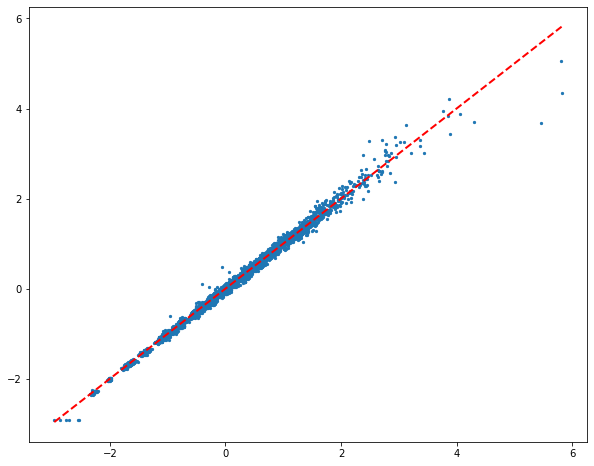

In [60]:
from sklearn.metrics import r2_score
import matplotlib
import matplotlib.pylab as plt

ytot_gp = means[1:].cpu().numpy() # torch to numpy 
ytst.cpu()
r2 = r2_score(ytot_gp,ytst.cpu())

plt.figure(figsize=(10,8))
plt.scatter(ytot_gp,ytst.cpu(),s=5)

low = np.min(np.stack((ytot_gp,ytst.cpu())).flatten())
high = np.max(np.stack((ytot_gp,ytst.cpu())).flatten())
plt.plot([low, high], [low, high], ls="--", c="red",lw=2.)

# plt.title('H3O+ PES (N=%s)'%N,fontsize=18)
# plt.text(0.02,0.08,r'$R^{2}$ = %.3f'%r2,fontsize=18)
# plt.xlabel('GP prediction',fontsize=18)
# plt.ylabel('Quantum Chemistry',fontsize=18)
# plt.show()

# Single molecule test case after training a GP model with GPytorch

In [23]:
# CH4
molec = '''
C 	0.000 	0.000 	0.000
H 	0.634 	0.634 	0.634
H 	-0.634 	-0.634 	0.634
H 	-0.634 	0.634 	-0.634
H 	0.634 	-0.634 	-0.634
'''
molec = molec.split()
molec = np.array(molec)
molec = molec.reshape(5,4)
print(molec)

[['C' '0.000' '0.000' '0.000']
 ['H' '0.634' '0.634' '0.634']
 ['H' '-0.634' '-0.634' '0.634']
 ['H' '-0.634' '0.634' '-0.634']
 ['H' '0.634' '-0.634' '-0.634']]


In [29]:
def get_atomic_number(atoms):
    atomic_numbers = {'H':1.,'C':6,'O':8}
    Z = []
    for x in molec:
        zi = atomic_numbers[x[0]]
        Z.append(zi)
    return np.array(Z)

In [47]:
def get_Cmatrix(molec):
    atoms = molec[:,0]
    molec = molec[:,1:]
    Zii = get_atomic_number(atoms)

    XYZ = np.array(molec,dtype=np.float32)
    diff =  XYZ[np.newaxis,:] - XYZ[:,np.newaxis]
    R = np.linalg.norm(diff,axis=-1,ord=1)
    Zij = Zii[:,np.newaxis] * Zii[np.newaxis,:]
    Rdiag = np.eye(R.shape[0])
    R = R + Rdiag
    R_inv = 1./R
    C = Zij * R_inv
    
    C_diag = 0.5*np.power(Zii, 2.4)
    C[np.diag_indices(R.shape[0])] = C_diag
    C_pad = np.zeros((23,23))
    C_pad[:C.shape[0],:C.shape[1]] = C
    return C_pad

In [49]:
def get_eigenvalues(molecule):
    C_pad =get_Cmatrix(molecule)
    e,_ = np.linalg.eigh(C_pad)
    return e

In [66]:
e_ch4 = get_eigenvalues(molec)
xtst = torch.tensor(e_ch4).reshape(1,23)

model.eval()
likelihood.eval()
preds = likelihood(model(xtst))
mean = preds.mean.cpu()
print(mean)
print(Xtot[0])
print(ytot[0])

tensor([4.9671], dtype=torch.float64, grad_fn=<ViewBackward0>)
tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.2033,  0.2033,  0.2033,  0.4613, 37.7869],
       dtype=torch.float64)
tensor(5.0022, dtype=torch.float64)


In [85]:
# Benzene
molec = '''
  C        0.00000        1.40272        0.00000
  H        0.00000        2.49029        0.00000
  C       -1.21479        0.70136        0.00000
  H       -2.15666        1.24515        0.00000
  C       -1.21479       -0.70136        0.00000
  H       -2.15666       -1.24515        0.00000
  C        0.00000       -1.40272        0.00000
  H        0.00000       -2.49029        0.00000
  C        1.21479       -0.70136        0.00000
  H        2.15666       -1.24515        0.00000
  C        1.21479        0.70136        0.00000
  H        2.15666        1.24515        0.00000
  '''
molec = molec.split()
molec = np.array(molec)
molec = molec.reshape(12,4)

e = get_eigenvalues(molec)
xtst = torch.tensor(e).reshape(1,23)

model.eval()
likelihood.eval()
preds = likelihood(model(xtst))
mean = preds.mean.cpu().detach().numpy()
print('Atomization energy = %.3f kcal/mol'%float((mean[0]*std_data)+mu_data))
# https://cccbdb.nist.gov/ea2.asp
print('Benzene experimental atomization energy 1305.688 kcal/mol from NIST') 

Atomization energy = -1486.991 kcal/mol
Benzene experimental atomization energy 1305.688 kcal/mol from NIST
